In [1]:
!pip install polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 39.8 MB/s eta 0:00:00:00:0100:01


In [2]:
import polars as pl
import pandas as pd
from datetime import datetime, timedelta

In [3]:
dataframe_pl = pd.DataFrame({
    'enter': [1,2,3],
    'date' : [
        (datetime(2024,6,20)),
        (datetime(2024,7,13)),
        (datetime(2022,9,12))
    ]
    


})

In [4]:
print(dataframe_pl)

   enter       date
0      1 2024-06-20
1      2 2024-07-13
2      3 2022-09-12


In [8]:
df_pl_orders = pl.read_csv('../Sesion2/data/data_retail/orders', separator='|',has_header=False, new_columns=['order_id','order_date','order_customer_id','order_status'])

FileNotFoundError: No such file or directory (os error 2): ../Sesion2/data/data_retail/orders

In [ ]:
df_pl_orders.join(df_pl_order_items, left_on=)

In [ ]:
df_pl_orders.filter(pl.col('order_id')>1000)

In [9]:
import numpy as np 


In [10]:
filas = 2000
rng = np.random.default_rng(seed=7) #semillas hace el random una vez y despues devolvera los mismos valores 
data = {
    'precio': rng.exponential(scale=1000, size=filas),
    'anio': rng.integers(low=1995, high=2024, size=filas),
    'tipo': rng.choice(['A','B','C'], size=filas)
}

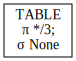

In [12]:
df_pl_lazy = pl.LazyFrame(data)
df_pl_lazy.show_graph()

In [14]:
lazy_query = (
    df_pl_lazy
    .with_columns(
        (pl.col('precio')/10).alias('precio_po_grupo')
    )
    .filter(pl.col("precio_poe_grupo")>100)
    .filter(pl.col("anio")>2010)
)
lazy_query.show_graph()

ColumnNotFoundError: unable to find column "precio_poe_grupo"; valid columns: ["precio", "anio", "tipo", "precio_po_grupo"]

This error occurred with the following context stack:
	[1] 'filter' failed
	[2] 'filter' input failed to resolve


In [15]:
import requests
import pathlib

def descarga(url: str,file_path: pathlib.Path):
    response = requests.get(url)

    if response:
        file_path.write_bytes(response.content)
    else: 
        print("Ocurrio un error")



In [16]:
url = "https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD"
file_path = pathlib.Path("cars.csv")

descarga(url, file_path)

In [17]:
lazy_car = pl.scan_csv(file_path)
lazy_car

In [19]:
lazy_car.select(pl.col('State')).collect()

State
str
"""WA"""
"""WA"""
"""WA"""
"""WA"""
"""WA"""
…
"""WA"""
"""WA"""
"""WA"""


In [ ]:
lazy_query = (
    lazy_car
    .filter(pl.col('Model Year') >= 2018)
    .filter(pl.col('Electric Vehicle Type') == "Battery Electric Vehicle(BI)")
    .group_by(['State', 'Make'])
    .agg(
        pl.mean("Electric Range").alias("Electric Range"),
        pl.len().alias("numero de carros")
    )
    .filter(pl.col("numero de carros")>5)
)
lazy_query